In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
master_df = pd.read_csv('../data/master_dataset_preds.csv')
master_df

,Open,Volume,Open_DXY,Volume_DXY,Open_lag_DXY,High_lag_DXY,Low_lag_DXY,Close_lag_DXY,Adj Close_lag_DXY,Volume_lag_DXY,...,Open_USL,Volume_USL,Open_lag_USL,High_lag_USL,Low_lag_USL,Close_lag_USL,Adj Close_lag_USL,Volume_lag_USL,actual_high_open,pred_high_open
0,546.000000,484738,89.599998,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,3.872201
1,546.559998,162138,89.639999,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.559997,4.036189
2,545.760010,156038,89.360001,0.0,0.040001,-0.089996,-0.090004,-0.279999,-0.279999,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.719970,4.138297
3,540.000000,70088,89.570000,0.0,-0.279998,0.070000,-0.180000,0.180001,0.180001,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.919983,4.934407
4,553.599976,114713,88.760002,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.600036,4.613822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,80.220001,4607100,106.160004,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,40.209999,29300.0,0.739998,0.040001,0.309998,-0.469997,-0.469997,1900.0,0.049996,0.850706
4415,78.040001,6629600,105.610001,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,39.360001,12600.0,-0.500000,-0.560001,-0.779999,-0.640003,-0.640003,23100.0,0.180000,0.936022
4416,77.110001,6116800,106.250000,0.0,-0.550003,-0.010002,-0.159996,0.729996,0.729996,0.0,...,39.060001,67700.0,-0.849998,-0.919998,-0.799999,-0.689999,-0.689999,-16700.0,1.620002,1.198983
4417,76.830002,3518500,106.580002,0.0,0.639999,0.250000,0.779998,0.260002,0.260002,0.0,...,39.000000,75400.0,-0.300000,0.509998,-0.170002,0.730000,0.730000,55100.0,0.759994,0.828545


In [20]:
def day_trading_strategy(df, delta_percent=0.0001):
    pnl = []

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0

    for day, day_info in df.iterrows():
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        
        delta = delta_percent * open

        if predicted_delta >= delta:
            pnl.append(actual_delta)

            if actual_delta > 0:
                num_profit_days += 1
            elif actual_delta < 0:
                num_loss_days += 1
            else:
                num_neutral_days +=1

        else:
            pnl.append(0)
            num_neutral_days += 1
    

    return pnl, num_profit_days, num_loss_days, num_neutral_days
   

In [17]:
num_test_days = 60
total_days = master_df.shape[0]

num_train_days = total_days - num_test_days
train_df = master_df.iloc[:num_train_days]
test_df = master_df.iloc[num_train_days:]

print(total_days)
print(train_df.shape)
print(test_df.shape)

4419
(4359, 40)
(60, 40)


Delta = 0.0% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.01% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.02% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.030000000000000002% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.04% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.05% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.060000000000000005% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.06999999999999999% ====> Average PNL = 2.5015139456297293$, Profitable Days = 4274, Lossy Days = 0, Neutral Days = 85
Delta = 0.08% ====> Average PNL = 2.50151394562972

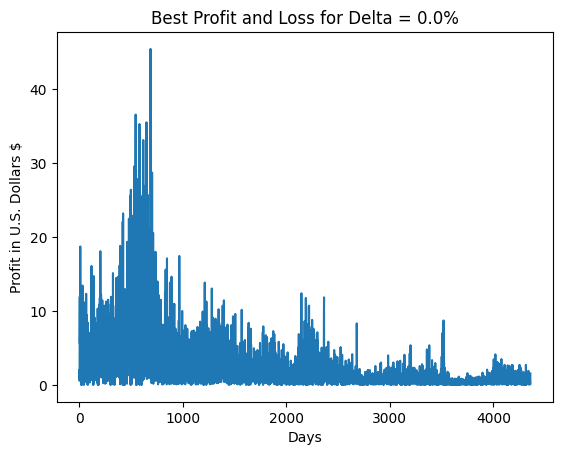

In [28]:
delta_percents = np.arange(0, 0.001, 0.0001)

best_avg_pnl = -1 * float('inf')
best_delta_percent = None
best_pnl = None
best_profit_days = None
best_loss_days = None
best_neutral_days = None

for delta_percent in delta_percents:
    pnl, num_profit_days, num_loss_days, num_neutral_days = day_trading_strategy(train_df, delta_percent=delta_percent)
   
    avg_pnl = sum(pnl) / len(pnl)

    if avg_pnl > best_avg_pnl:
        best_avg_pnl = avg_pnl
        best_delta_percent = delta_percent
        best_pnl = pnl
        best_profit_days = num_profit_days
        best_loss_days = num_loss_days
        best_neutral_days = num_neutral_days

    print(f"Delta = {delta_percent*100}% ====> Average PNL = {avg_pnl}$, Profitable Days = {num_profit_days}, Lossy Days = {num_loss_days}, Neutral Days = {num_neutral_days}")

print()

print(f'Best Delta = {best_delta_percent*100}% ===> Best Average PNL = {best_avg_pnl}$, Profitable Days = {best_profit_days}, Lossy Days = {best_loss_days}, Neutral Days = {best_neutral_days}')

plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(best_pnl)


Delta = 0.0% ===> Test Average PNL = 0.5786663000000002$, Profitable Days = 58, Lossy Days = 0, Neutral Days = 2


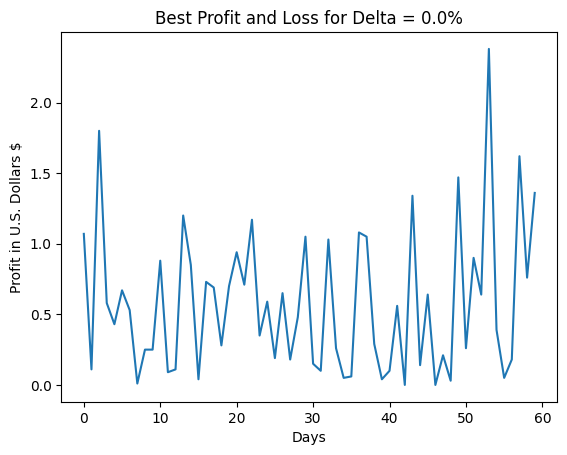

In [30]:
test_pnl, test_num_profit_days, test_num_loss_days, test_num_neutral_days = day_trading_strategy(test_df, delta_percent=best_delta_percent)

test_avg_pnl = sum(test_pnl) / len(test_pnl)

print(f'Delta = {best_delta_percent*100}% ===> Test Average PNL = {test_avg_pnl}$, Profitable Days = {test_num_profit_days}, Lossy Days = {test_num_loss_days}, Neutral Days = {test_num_neutral_days}')


plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(test_pnl)